## TARGET PROBABILITY
In this experiment, we would attempt to calculate the probability of a price target getting reached, within a period of time.

### PARAMETERS
- Forecast time range - `t_lback`
- Forecast time range = `t_delta`

#### PROCEDURE

###### Feature Engineering
- Calculate the ATR with a period of `t_lback`
- Compute the closing price returns; price change from the previous data point
- Compute the maximum and minimum price displacement from the current price.
- Compute the ratios of the maximum/minimum price displacement

###### Probability Analysis
- Compute the distribution of assets return, over t_delta bars. Derive the standard deviation of the returns, and the proportion of data within 1, 2, and 3 STD
- Compute the probability of a target being reached; the probability of selecting an asset return equal to or greater than the target

In [1]:
# Import the data
import talib as tal
import pandas as pd
from pathlib import Path
import pandas_ta as ta
import quantstats as qt #noqa
import numpy as np
import seaborn as sns #noqa
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad

# Parameters
t_lback = 14
t_delta = 14
p_value = 0.05

# Data Paths
aapl_path = Path.cwd().parent / 'data/aapl_h1.csv'
btc_path = Path.cwd().parent / 'data/btcusdt_h1.parquet'
gold_path = Path.cwd().parent / 'data/gold_h1.parquet'

In [2]:
# Functions
def get_distribution(data, title, target_multiplier=1):

    data = np.abs(data)

    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    
    print("Mean : ", mean)
    print("Standard Deviation : ", std)

    print(f"Probability of reaching a target of the mean is : {target_probability_kde(data, mean * target_multiplier)}")
    print(f"Probability of reaching a target of 1 STD is : {target_probability_kde(data, std * target_multiplier)}")
    
   # Adjust the plot size
    plt.figure(figsize=(4, 3))  # You can adjust the figsize values as per your needs
    
    # Plot the distribution
    plt.hist(data, bins=30, color='lightblue', edgecolor='black') 

    # Add vertical lines for mean and median
    plt.axvline(x=mean, color='blue', linestyle='--', label='Mean')
    plt.axvline(x=median, color='red', linestyle='--', label='Median')

    # Customization
    plt.title(f"Distribution of {title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()  # Show the labels

    plt.show()

    plt.show()

def target_probability(data, test_value):
    """
    Calculates the probability of the target getting reached.
    
    Args:
        data (array-like): An array containing the distribution of values.
        test_value: The value to test against.
        
    Returns:
        float: The probability of selecting a number below the test value.
    """
    
    # Find the number of data points less than or equal to the test value
    count = np.sum(data >= test_value)
    
    # Calculate the probability
    probability = count / len(data)
    
    return round(probability, 2)

def target_probability_kde(data, test_value):
    """
    Calculates the probability of selecting a number greater than or equal to a test value
    using Kernel Density Estimation (KDE), with integration bounds adjusted for robustness.
    
    Args:
        data (array-like): An array containing the distribution of values.
        test_value (float): The value to test against.
        
    Returns:
        float: The probability of selecting a number above or equal to the test value.
    """
    # Define KDE
    kde = gaussian_kde(data)
    
    # Calculate standard deviation for the bounds
    std = np.std(data)
    upper_bound = max(data) + (3 * std)
    
    # Integration from test_value to upper bound for the probability
    probability, _ = quad(kde, test_value, upper_bound)
    
    return round(probability, 2)


# Function to compute KPI 
def compute_kpis(returns):
    returns = pd.Series(returns)
    print(
            f'Profit Ratio: {qt.stats.profit_ratio(returns)}\n',
            f'Win Rate: {qt.stats.win_rate(returns)}\n'
            f'Sharpe : {qt.stats.sharpe(returns)}\n', 
            f'Profit Factor : {qt.stats.profit_factor(returns)}\n',
            f'Martin Ratio : {qt.stats.ulcer_performance_index(returns)}')

In [3]:
# Read Data
# raw_data = pd.read_parquet(gold_path)
# raw_data.reset_index(names=['datetime'], inplace=True)

raw_data = pd.read_csv(aapl_path)
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])

display(raw_data.head(2))
display(raw_data.tail(2))

,datetime,open,high,low,close,volume
0,1998-01-02 16:00:00,0.12,0.12,0.12,0.12,14512400
1,1998-01-02 17:00:00,0.12,0.13,0.12,0.12,52987312


,datetime,open,high,low,close,volume
46340,2023-12-28 22:00:00,193.88,194.09,193.87,193.97,1881975
46341,2023-12-28 23:00:00,193.97,193.97,193.17,193.59,5435335


In [4]:
# FEATURE ENGINEERING

# Filter the date range
data = raw_data[(raw_data['datetime'].dt.year >= 2010) & (raw_data['datetime'].dt.year <= 2023)]
data = data.reset_index(drop=True)

# Compute Returns
returns = data['close'].diff().fillna(0)
returns_perc = data['close'].pct_change(fill_method=None).fillna(0)

# Handle Outlier in Returns : Replace with the mean
mean_return = np.mean(returns)
mean_return_perc = np.mean(returns_perc)

returns.loc[returns.abs() > np.percentile(returns.abs(), 99.5)] = mean_return # Replace outliers: returns greater than 99th percentile
returns_perc.loc[returns_perc.abs() > np.percentile(returns_perc.abs(), 99.5)] = mean_return_perc # Replace outliers: returns greater than 99th percentile

# Feature Engineering
data['atr'] = tal.ATR(
    data['high'], 
    data['low'], 
    data['close'], 
    t_lback)
data['next_returns'] = returns.shift(-1)
data['returns_perc'] = returns_perc

data['ema'] = ta.ema(data['close'].copy(deep=True), 20)


data['max_runup'] = data['next_returns'].rolling(t_delta).apply(
    lambda x : max(
        np.cumsum(
            np.pad(x, (1, 0), mode='constant', constant_values=0)))).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars

data['max_rundown'] = data['next_returns'].rolling(t_delta).apply(
    lambda x : min(
        np.cumsum(
            np.pad(x, (1, 0), mode='constant', constant_values=0)))).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars

data['runup_atr_ratio'] = data['max_runup'] / data['atr']
data['rundown_atr_ratio'] = data['max_rundown'] / data['atr']

# Drop NaNs
data = data.dropna(axis=0).reset_index(drop=True)

full_data = data.copy()
# data = data.drop(['open', 'high', 'low', 'volume', 'datetime'], axis=1)

# Print Sample
display(data.shape)
data.head(3)


(25218, 14)

,datetime,open,high,low,close,volume,atr,next_returns,returns_perc,ema,max_runup,max_rundown,runup_atr_ratio,rundown_atr_ratio
0,2010-01-06 21:00:00,7.55,7.61,7.54,7.57,19858902,0.044454,-0.04,0.002649,7.634500,0.03,-0.05,0.674857,-1.124762
1,2010-01-06 22:00:00,7.57,7.58,7.52,7.53,23676842,0.045564,-0.03,-0.005284,7.624548,0.06,-0.02,1.316821,-0.438940
2,2010-01-07 16:00:00,7.56,7.57,7.48,7.50,25827886,0.048738,0.03,-0.003984,7.612686,0.03,-0.05,0.615533,-1.025888


#### DISTRIBUTIONS

Mean :  1.9514965308910752
Standard Deviation :  2.127642144013627
Probability of reaching a target of the mean is : 0.39
Probability of reaching a target of 1 STD is : 0.36


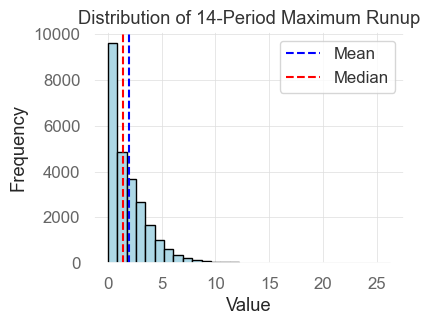

Mean :  1.6753231541999025
Standard Deviation :  1.9696238650322941
Probability of reaching a target of the mean is : 0.37
Probability of reaching a target of 1 STD is : 0.32


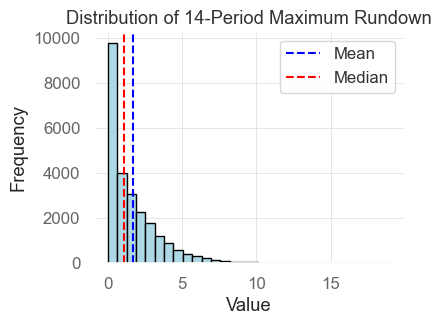

In [5]:
get_distribution(data['runup_atr_ratio'], f'{t_delta}-Period Maximum Runup')
get_distribution(data['rundown_atr_ratio'], f'{t_delta}-Period Maximum Rundown')

Mean :  2.030564719729057
Standard Deviation :  2.233227170389093
Probability of reaching a target of the mean is : 0.6
Probability of reaching a target of 1 STD is : 0.57


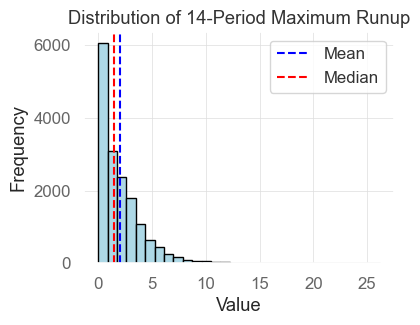

Mean :  1.6470833479129325
Standard Deviation :  1.9857217049092446
Probability of reaching a target of the mean is : 0.55
Probability of reaching a target of 1 STD is : 0.51


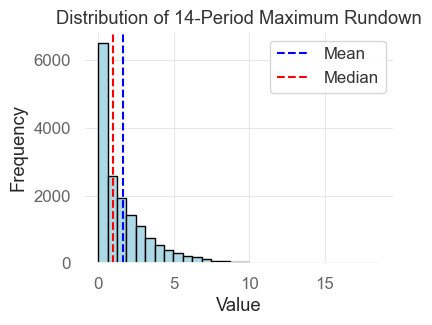

In [6]:
get_distribution(data.loc[data['close'] > ta.ema (data.close, 200), 'runup_atr_ratio'], f'{t_delta}-Period Maximum Runup', .5)
get_distribution(data.loc[data['close'] > ta.ema (data.close, 200), 'rundown_atr_ratio'], f'{t_delta}-Period Maximum Rundown', .5)

##### CONCLUSION
1. The distribution of aseet returns move above/below relative to the current ATR value :
  - Mean Runup : 1.8 times
  - Mean Rundown : -1.6 times
The standard deiation for both distributions, however are significant, and larger than the mean, This implies that the variation within the distribution is wide.

2. When a condition is applied (filtered by ema for example), similar mean values are gotten, and the level of variation is still high

Due to the large variation in the data, teh probability density is also a bit messy. For the base case as well as with the conditions applied, the probability of gettign a return the same as the mean value is less than 40%.

For a minimum of 70% certainity, the target atr multiple should be `.2`



#### TEST:
Using the calculated mean distribution of the `t_delta` returns, we would test its effectiveness as an exit strategy.
- First, we would code the entry strategy; Buy engulfing pattern (high > high[1] and close < close[1]) when above the SMA 168
- Next, we would compute the benchmark exit strategy : using a holding period of `t_delta`. The Profit Factor, Sharpe Ratio and Ulcer Performance Ratio would be calculated.
- Finally, we would implement an exit of the mean (1.8) times the current ATR value as the exit price. Same KPIs would be computed

In [7]:
# Entry Features and Conditions
ema_filter = ta.sma(data['close'], 168)
bull_engulfing = np.where((data['high'] > data['high'].shift(1)) &  (data['close'] < data['close'].shift(1)), 1, 0)
bear_engulfing = np.where((data['low'] < data['low'].shift(1)) &  (data['close'] > data['close'].shift(1)), 1, 0)

data['entry_signal'] = (data['close'] > ema_filter) & bull_engulfing 

In [8]:
# Initialize signal column to zeros
data['signals_baseline'] = 0

# Create a temporary extension of the condition to capture the next 5 rows for each condition met
for i in range(1, t_delta + 1):
    # Use `shift` to move the condition mask up by i positions, expanding the range where condition is considered True
    data['signals_baseline'] |= data['entry_signal'].shift(i, fill_value=0)

# Replace True/False with 1/0 in the 'signal' column
data['signals_baseline'] = data['signals_baseline'].astype(int)

In [9]:
print("----- Baseline Performance : Holding Period Exit -----")
baseline_returns = data.loc[data['signals_baseline'] == 1, 'returns_perc']
compute_kpis(baseline_returns)
# plt.plot(np.cumsum(baseline_returns))

----- Baseline Performance : Holding Period Exit -----
Profit Ratio: 0.7367719502693997
 Win Rate: 0.524168441749959
Sharpe : 0.46885272337255607
 Profit Factor : 1.0939016042777794
 Martin Ratio : 43.83621745375225


In [10]:
# Test 1 : Exit Strategy (with no stop loss)
data['target_above'] = data['close'] + (data['atr'] * 1.8)
data['target_below'] = data['close'] - (data['atr'] * 1.5) 
data['signals_1'] = 0

# Initialize a flag to track if we are currently in an active signal phase
in_signal = False
current_target_above = 0
current_target_below = 0

# Iterate through the DataFrame rows
for i in range(len(data)):
    if in_signal:
        # Checks if either target is met (We exit the signal)
        if (data.loc[i, 'close'] >= current_target_above): # or (data.loc[i, 'close'] <= current_target_below):
            in_signal = False # Reset the flag as target is met
    else:
        # Check for the start of a new signal
        if data.loc[i, 'entry_signal'] == 1:
            in_signal = True
            current_target_above = data.loc[i, 'target_above']
            current_target_below = data.loc[i, 'target_below']
    
    # If we're in an active signal phase, set 'signal' to 1
    data.loc[i, 'signals_1'] = 1 if in_signal else 0


In [11]:
print("----- Backtest 1 Performance : Profit Target -----")
backtest_returns_1 = data.loc[data['signals_1'] == 1, 'returns_perc']
compute_kpis(backtest_returns_1)
# plt.plot(np.cumsum(backtest_returns_1))

----- Backtest 1 Performance : Profit Target -----
Profit Ratio: 0.7884264205415973
 Win Rate: 0.5105742894346909
Sharpe : 0.17497708045744728
 Profit Factor : 1.0337295705900609
 Martin Ratio : 12.986171426251952


In [12]:
# Test 2 : Exit - Profit Target and Max Holding Period
data['signals_2'] = 0

# Initialize a flag to track if we are currently in an active signal phase
in_signal = False
current_target_above = 0
rows_since_signal = 0

# Iterate through the DataFrame rows
for i in range(len(data)):
    was_valid = in_signal and rows_since_signal < t_delta
    # Check for the start of a new signal
    if data.loc[i, 'entry_signal'] == 1:
        rows_since_signal = -1
        in_signal = True
        current_target_above = data.loc[i, 'target_above']
    
    if in_signal:
        # Checks if either target is met (We exit the signal)
        if (data.loc[i, 'close'] >= current_target_above) or (rows_since_signal >= t_delta):
            in_signal = False # Reset the flag as target is met
            rows_since_signal = 0

        else:
            rows_since_signal += 1

        if (rows_since_signal > 0) or was_valid:
            # If we're in an active signal phase, set 'signal' to 1
            data.loc[i, 'signals_2'] = 1
        
    

In [13]:
print("----- Backtest 2 Performance : Profit Target and Holding Period -----")
backtest_returns_2 = data.loc[data['signals_2'] == 1, 'returns_perc']
compute_kpis(backtest_returns_2)
# plt.plot(np.cumsum(backtest_returns_2))

----- Backtest 2 Performance : Profit Target and Holding Period -----
Profit Ratio: 0.7381977245458321
 Win Rate: 0.5217095015576324
Sharpe : 0.3686514354593245
 Profit Factor : 1.0732707004968534
 Martin Ratio : 18.120750853786692


##### CONCLUSION:
- The distribution of asset_return over `t_delta` bars, contain too much variability to have any significance as a profit target estimator. The low probabilities of reaching or surpassing a target equal to the mean asset price displacement over `t_delta` bars, iterates this point.